## Base libraries and tools imports

In [1]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import os
import math
from sklearn.model_selection import train_test_split

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
VAL_SPLIT = 0.2

2025-04-14 22:10:24.547366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744668624.756412      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744668624.812385      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Dataset and Image Processing Functions

In [2]:
def load_dataset_files(directory):
    """Loads file paths and labels from the directory"""
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    classes = {class_name: i for i, class_name in enumerate(class_dirs)}

    file_paths = []
    labels = []

    for class_name in class_dirs:
        class_dir = os.path.join(directory, class_name)
        class_idx = classes[class_name]

        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                 if os.path.isfile(os.path.join(class_dir, f)) and
                 f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        file_paths.extend(files)
        labels.extend([class_idx] * len(files))

    return file_paths, labels, classes


def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    label = tf.cast(label, tf.float32)
    return img, label

The load_dataset_files function recursively scans through a directory structure, where each subdirectory represents a class, and builds lists of file paths and corresponding labels. The process_image function handles the transformation pipeline for individual images, including reading the file, decoding the JPEG, resizing to the target dimensions, and normalizing pixel values to the [0,1] range for model compatibility.  
## Micro F1-Score Metric Function


In [3]:
def micro_f1(y_true, y_pred):
    y_pred = tf.squeeze(y_pred, axis=-1)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarization

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))  # True Positives
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))  # False Positives
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))  # False Negatives

    precision = tp / (tp + fp + tf.keras.backend.epsilon())  # Add a small number to avoid /0
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    return f1

This custom TensorFlow function calculates the micro F1-score for binary classification by computing precision and recall from true positives, false positives, and false negatives, then combining them into the harmonic mean.  
# First Attempt: Class-Weighted EfficientNetB5 Model  
For this initial approach, I decided to address the significant class imbalance by implementing class weights during training. The architecture consists of an EfficientNetB7 base with a custom head layer configuration. The model uses Binary Cross-Entropy as the loss function and incorporates both EarlyStopping and ReduceLROnPlateau callbacks to optimize training efficiency and prevent overfitting.  
To prepare the data, the create_train_val_datasets function handles the dataset creation process. It loads image files from the specified directory, performs a stratified split to maintain class distribution between training and validation sets, and returns properly configured TensorFlow datasets.



In [4]:
def create_train_val_datasets(train_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE, val_split=VAL_SPLIT):
    """Creates training and validation datasets from a single directory"""
    # Load files and labels
    file_paths, labels, classes = load_dataset_files(train_dir)
    
    # Split into training and validation sets with stratification
    train_files, val_files, train_labels, val_labels = train_test_split(
        file_paths, labels, test_size=val_split, stratify=labels, random_state=42
    )
    
    print(f"Classes: {classes}")
    print(f"Total number of images: {len(file_paths)}")
    print(f"Number of training images: {len(train_files)}")
    print(f"Number of validation images: {len(val_files)}")
    
    # Create training dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
    train_ds = train_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(buffer_size=len(train_files))
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    # Create validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
    val_ds = val_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    # Calculate number of steps
    train_steps = math.ceil(len(train_files) / batch_size)
    val_steps = math.ceil(len(val_files) / batch_size)
    train_ds = train_ds.repeat()
    val_ds = val_ds.repeat()
    
    return train_ds, val_ds, train_steps, val_steps, classes


train_ds, val_ds, train_steps, val_steps, train_classes = create_train_val_datasets(
    train_dir='/kaggle/input/faces-artefact-recognition/trainee_dataset/train', 
    img_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    val_split=0.2
)

Classes: {'artifacts': 0, 'no artifacts': 1}
Total number of images: 1795
Number of training images: 1436
Number of validation images: 359


I0000 00:00:1744668644.159047      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Model Architecture - EfficientNetB5 with Custom Classification Head

In [5]:
base_model = tf.keras.applications.EfficientNetB5(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_micro_f1', 
        patience=7, 
        restore_best_weights=True, 
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_micro_f1', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-7, 
        mode='max'
    ),
]

## Training Configuration with Class Weights

In [7]:
model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='binary_crossentropy',
    metrics=['accuracy', micro_f1]
)

class_weights = {
    0: 8.0,
    1: 1
}

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1744668709.666161      75 service.cc:148] XLA service 0x7d41440af790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744668709.667302      75 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744668714.107113      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/45 ━━━━━━━━━━━━━━━━━━━━ 1:04:47 88s/step - accuracy: 0.4062 - loss: 1.4291 - micro_f1: 0.4865

I0000 00:00:1744668737.670618      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.3439 - loss: 1.1771 - micro_f1: 0.4495 - val_accuracy: 0.1003 - val_loss: 0.7091 - val_micro_f1: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.3972 - loss: 1.1763 - micro_f1: 0.5290 - val_accuracy: 0.3315 - val_loss: 0.6963 - val_micro_f1: 0.4464 - learning_rate: 1.0000e-06
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - accuracy: 0.4450 - loss: 1.1369 - micro_f1: 0.5823 - val_accuracy: 0.8942 - val_loss: 0.6853 - val_micro_f1: 0.9421 - learning_rate: 1.0000e-06
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.4708 - loss: 1.1603 - micro_f1: 0.6040 - val_accuracy: 0.8997 - val_loss: 0.6775 - val_micro_f1: 0.9451 - learning_rate: 1.0000e-06
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.5151 - loss: 1.1656 - micro_f1: 0.6510 - val_accuracy: 0.8997 - val_loss: 0.6700 - val_micro_f1: 0.9451 - learning_rate: 1.0000e-06
Epoch 6/10
45/4

The model training exhibits clear signs of class imbalance issues. With 200 artifact images versus 1600 non-artifact images (8:1 ratio), the model appears to have converged to a degenerate solution where it classifies nearly all images as "without artifacts." This is evidenced by the validation accuracy stabilizing at 89.97% from epoch 4 onwards, which almost perfectly matches the expected accuracy if the model simply predicted the majority class for all inputs.  

The micro F1 score on validation data quickly plateaued at 0.9451, further supporting this conclusion. Despite the training metrics showing gradual improvement (accuracy increasing from 34% to 59%), the validation metrics remained completely static after epoch 4, triggering early stopping. The model likely learned to minimize loss by simply predicting the dominant class rather than identifying meaningful features that distinguish artifacts in images.  

# Second Attempt: Fine-tuned ResNet50 with Focal Loss  
For this second approach, I decided to switch from EfficientNetB5 to ResNet50 as the base architecture while maintaining class weights to address data imbalance. A key improvement in this iteration is implementing Focal Loss instead of Binary Cross-Entropy to further tackle the class imbalance by focusing more on hard-to-classify examples. The model features an expanded head with larger dense layers, batch normalization, and strategic dropout layers for better regularization. Additionally, I unfroze the last 40 layers of the base ResNet50 model to allow fine-tuning of higher-level features while keeping earlier layers fixed.
## Focal Loss Implementation for Class Imbalance  

In [12]:
def focal_loss_binary(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculating focal loss for binary classification
        loss_pos = -alpha * K.pow(1. - y_pred, gamma) * y_true * K.log(y_pred)
        loss_neg = -(1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true) * K.log(1. - y_pred)

        return K.mean(loss_pos + loss_neg)
    return loss

## ResNet50 Model with Extended Classification Head

In [13]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-40]:
    layer.trainable = False
for layer in base_model.layers[-40:]:
    layer.trainable = True
    
# Build the new model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

This implementation creates a partially unfrozen ResNet50 model with an extended classification head consisting of multiple dense layers with batch normalization, ReLU activation, and dropout regularization for improved generalization performance.  
## Training Configuration

In [16]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_micro_f1', 
        patience=7, 
        verbose=1
        restore_best_weights=True, 
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_micro_f1', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-7, 
        mode='max'
    ),
]

In [17]:
model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss=focal_loss_binary(),
    metrics=['accuracy', micro_f1]
)

class_weights = {
    0: 8.0,
    1: 1
}

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 76s 693ms/step - accuracy: 0.4445 - loss: 0.1794 - micro_f1: 0.5813 - val_accuracy: 0.1003 - val_loss: 0.0818 - val_micro_f1: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.5128 - loss: 0.1747 - micro_f1: 0.6436 - val_accuracy: 0.3231 - val_loss: 0.0596 - val_micro_f1: 0.4020 - learning_rate: 1.0000e-06
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.4986 - loss: 0.1427 - micro_f1: 0.6283 - val_accuracy: 0.5042 - val_loss: 0.0558 - val_micro_f1: 0.6451 - learning_rate: 1.0000e-06
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.4949 - loss: 0.1543 - micro_f1: 0.6322 - val_accuracy: 0.6546 - val_loss: 0.0495 - val_micro_f1: 0.7681 - learning_rate: 1.0000e-06
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.4963 - loss: 0.1390 - micro_f1: 0.6246 - val_accuracy: 0.7187 - val_loss: 0.0473 - val_micro_f1: 0.8115 - learning_rate: 1.0000e-06
Ep

The switch to ResNet50 architecture with unfrozen layers and focal loss shows notable improvement over the previous approach. Unlike the prior model that converged to simply predicting the majority class, this model demonstrates more meaningful learning. The validation accuracy peaked at 72.70% in epoch 6, significantly below the 89.97% that would indicate classifying everything as "no artifacts," suggesting better discrimination between classes.  

The focal loss appears to have effectively addressed the class imbalance problem, with validation micro F1 scores reaching 0.8161, indicating reasonable performance on both classes. However, after epoch 6, both validation accuracy and F1 score began declining while training metrics continued improving, revealing classic overfitting behavior. The early stopping mechanism correctly identified epoch 6 as optimal, preventing further overfitting to the training data. This model shows promise but would likely benefit from additional regularization techniques to maintain generalization capability.  

# Third Attempt: VGG16 with Oversampling and Augmentation  

For this third approach, I completely reimagined the data preparation strategy by implementing oversampling and adding data augmentation to address class imbalance directly at the dataset level. Moving away from the larger ResNet50, I switched to the more compact VGG16 architecture and fully unfroze all its layers for complete fine-tuning across the network. To improve training dynamics, I incorporated an ExponentialDecay learning rate schedule for smoother learning rate reduction during later epochs. I maintained the class weights approach since it aligns with the expected real-world distribution ratio of 1:8 between classes, which helps prepare the model for deployment conditions while still handling the training data effectively.  


In [20]:
def new_augment_image(image, label):
    # Horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Brightness
    image = tf.image.random_brightness(image, max_delta=0.15)

    # Contrast
    image = tf.image.random_contrast(image, 0.85, 1.15)

    # Saturation
    image = tf.image.random_saturation(image, 0.9, 1.1)

    # Hue
    image = tf.image.random_hue(image, max_delta=0.05)

    # Random Gaussian blur (only 30% of the time)
    if tf.random.uniform(()) > 0.7:
        # Use tf.nn.gaussian_blur via tf.image. stateless_random_brightness
        image = tf.image.stateless_random_brightness(
            image,
            max_delta=0.0,
            seed=[42, 42]
        )

    # Trim values to stay within [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [21]:
import pandas as pd

def create_balanced_train_dataset(train_dir, batch_size=BATCH_SIZE, val_split=0.2):
    """Create a balanced training dataset with oversampling for train and a separate validation"""
    file_paths, labels, classes = load_dataset_files(train_dir)

    df = pd.DataFrame({'file_path': file_paths, 'label': labels})

    # Split into train/val BEFORE oversampling
    train_df, val_df = train_test_split(
        df,
        test_size=val_split,
        stratify=df['label'],
        random_state=42
    )

    print(f"Classes: {classes}")
    print(f"Total number of images: {len(file_paths)}")
    print(f"Number of training images: {len(train_df)}")
    print(f"Number of validation images: {len(val_df)}")

    # Oversampling only on the training part
    class_counts = train_df['label'].value_counts().to_dict()

    minority_label = min(class_counts, key=class_counts.get)
    majority_label = max(class_counts, key=class_counts.get)

    minority_df = train_df[train_df['label'] == minority_label]
    majority_df = train_df[train_df['label'] == majority_label]

    # Amount of "minority" after oversampling: e.g. 50-70% of the majority
    target_minority_count = int(len(majority_df) * 1.0)
    oversampled_minority_df = minority_df.sample(target_minority_count, replace=True, random_state=42)

    balanced_df = pd.concat([majority_df, oversampled_minority_df])
    balanced_df = balanced_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

    print(f"After oversampling: {balanced_df['label'].value_counts().to_dict()}")

    # ---- TRAIN DATASET ----
    train_ds = tf.data.Dataset.from_tensor_slices((balanced_df['file_path'].values, balanced_df['label'].values))
    train_ds = train_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(new_augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(buffer_size=len(balanced_df))
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    train_ds = train_ds.repeat()

    steps_per_epoch = math.ceil(len(balanced_df) / batch_size)

    # ---- VALIDATION DATASET ----
    val_ds = tf.data.Dataset.from_tensor_slices((val_df['file_path'].values, val_df['label'].values))
    val_ds = val_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.repeat()

    val_steps = math.ceil(len(val_df) / batch_size)

    return train_ds, steps_per_epoch, val_ds, val_steps, classes


balanced_train_ds, balanced_steps, val_ds, val_steps, _ = create_balanced_train_dataset(
    train_dir='/kaggle/input/faces-artefact-recognition/trainee_dataset/train',
    batch_size=BATCH_SIZE,
    val_split=0.2

)

Classes: {'artifacts': 0, 'no artifacts': 1}
Total number of images: 1795
Number of training images: 1436
Number of validation images: 359
After oversampling: {0: 1292, 1: 1292}


This function creates a strategically balanced training dataset through controlled oversampling of the minority class. It first splits the data into training and validation sets while preserving the original class distribution, then applies oversampling only to the training portion. The minority class is oversampled to match the majority class (1:1 ratio), significantly addressing class imbalance without affecting validation integrity. The training pipeline incorporates data augmentation for improved generalization, while both datasets utilize TensorFlow's performance optimization features like prefetching and parallel processing.  
## Fully-trainable VGG-19 Model with Custom Classification Head

In [22]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# Build the new model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor="val_micro_f1",
        mode="max",
        save_best_only=True,
        verbose=1
    )
]

## Training Configuration

In [26]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-5,
        decay_steps=400,         # approximately every epoch (81 batches = ~1 epoch)
        decay_rate=0.85,          # smooth drop
        staircase=True           # discretely, in steps
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=focal_loss_binary(),
    metrics=['accuracy', micro_f1]
)

class_weights = {
    0: 8.0,
    1: 1
}

history = model.fit(
    balanced_train_ds,
    validation_data=val_ds,
    epochs=20,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    steps_per_epoch=balanced_steps,
    validation_steps=val_steps,
    callbacks=callbacks
)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.5581 - loss: 0.5269 - micro_f1: 0.2461
Epoch 1: val_micro_f1 improved from -inf to 0.00000, saving model to best_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 123s 785ms/step - accuracy: 0.5586 - loss: 0.5260 - micro_f1: 0.2475 - val_accuracy: 0.1003 - val_loss: 0.0911 - val_micro_f1: 0.0000e+00
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7281 - loss: 0.2424 - micro_f1: 0.6406
Epoch 2: val_micro_f1 did not improve from 0.00000
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 319ms/step - accuracy: 0.7284 - loss: 0.2422 - micro_f1: 0.6412 - val_accuracy: 0.1003 - val_loss: 0.1082 - val_micro_f1: 0.0000e+00
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8426 - loss: 0.1358 - micro_f1: 0.8249
Epoch 3: val_micro_f1 improved from 0.00000 to 0.19878, saving model to best_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 56s 337ms/step - accuracy: 0.8428 - loss: 0.1357 - micro_f1: 0.8251 - val_accuracy: 0.1894 - val_loss: 

The third approach demonstrates impressive results, showing significant improvement over previous models. By implementing oversampling and data augmentation to directly address the class imbalance at the dataset level, combined with a fully unfrozen VGG16 architecture, the model achieved remarkable performance metrics.  
The training progression shows good learning dynamics, with validation micro F1 score steadily improving from 0 to a peak of 0.9743 by epoch 15. Unlike previous attempts where the model either converged to predicting the majority class or showed early signs of overfitting, this approach maintained strong generalization capabilities throughout training. The training accuracy reached near-perfect levels (99.86%) while validation metrics remained high without collapsing.  
The exponential decay learning rate schedule appears to have effectively stabilized later training epochs, preventing dramatic overfitting despite 20 full epochs of training. While there were minor fluctuations in validation metrics after epoch 15, the model maintained strong performance, indicating robust feature learning. This approach successfully balanced the 1:8 class ratio challenge through a comprehensive combination of data-level and model-level strategies, making it the most promising solution for the artifact detection task.  
 
# Model evaluation

In [28]:
def create_test_dataset(test_dir, batch_size=BATCH_SIZE):
    file_paths, labels, classes = load_dataset_files(test_dir)

    print(f"Classes in the test set: {classes}")
    print(f"Number of test images: {len(file_paths)}")

    # Create test dataset
    test_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    test_ds = test_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size, drop_remainder=True)
    test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Calculate the number of steps
    test_steps = len(file_paths) // batch_size + (1 if len(file_paths) % batch_size != 0 else 0)

    return test_ds, test_steps, classes

# For testing
test_ds, test_steps, test_classes = create_test_dataset(
    test_dir='/kaggle/input/faces-artefact-recognition/trainee_dataset/test',
    batch_size=BATCH_SIZE
)

Classes in the test set: {'artifacts': 0, 'no artifacts': 1}
Number of test images: 200



📊 Classification Report:
              precision    recall  f1-score   support

   artifacts       0.86      0.60      0.71        20
no artifacts       0.96      0.99      0.97       172

    accuracy                           0.95       192
   macro avg       0.91      0.79      0.84       192
weighted avg       0.94      0.95      0.94       192



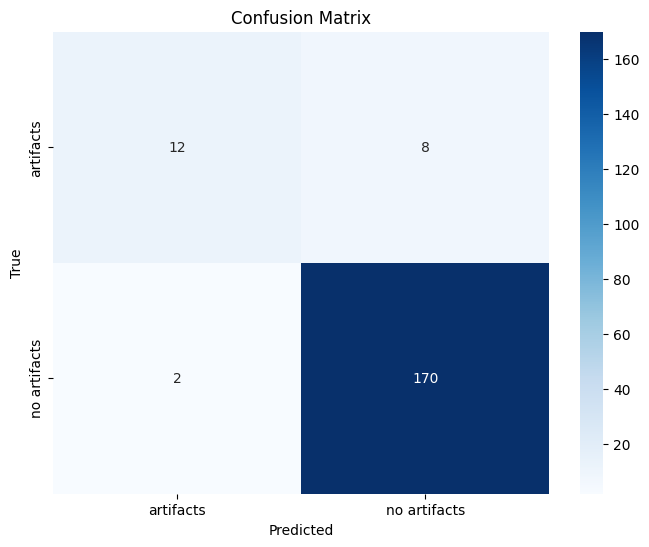

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model = tf.keras.models.load_model("best_model.keras", compile=False)

def evaluate_model_on_test(model, test_ds, test_steps, class_names=None):
    y_true = []
    y_pred = []

    for images, labels in test_ds.take(test_steps):
        preds = model.predict(images, verbose=0)

        # If the model returns probabilities
        if preds.shape[-1] > 1:
            pred_classes = np.argmax(preds, axis=1)
        else:
            pred_classes = (preds > 0.5).astype(int).flatten()

        y_pred.extend(pred_classes)
        y_true.extend(labels.numpy().astype(int))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # ---- Metrics ----
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'confusion_matrix': cm,
        'report': classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    }


results = evaluate_model_on_test(model, test_ds, test_steps, test_classes)

The classification report and confusion matrix reveal important insights about the model's performance on imbalanced test data. While the overall accuracy of 95% appears promising, examining class-specific metrics provides a more nuanced understanding.
For the minority "artifacts" class, the model achieved 60% recall (12/20 correct), indicating it still misses 40% of artifact cases. The precision of 86% shows that when the model predicts an artifact, it's usually correct, with only 2 false positives. The resulting F1-score of 0.71 for artifacts highlights room for improvement in detecting this critical class.  
The majority "no artifacts" class performs exceptionally well with 99% recall and 96% precision, demonstrating near-perfect classification. However, this stark contrast between class performances suggests the model still somewhat favors the majority class despite the implemented balancing techniques. This behavior is common in highly imbalanced problems where the 1:8 ratio persists in real-world applications. Further optimization might focus specifically on improving minority class recall without significantly compromising the current low false positive rate.  
## Prediction visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


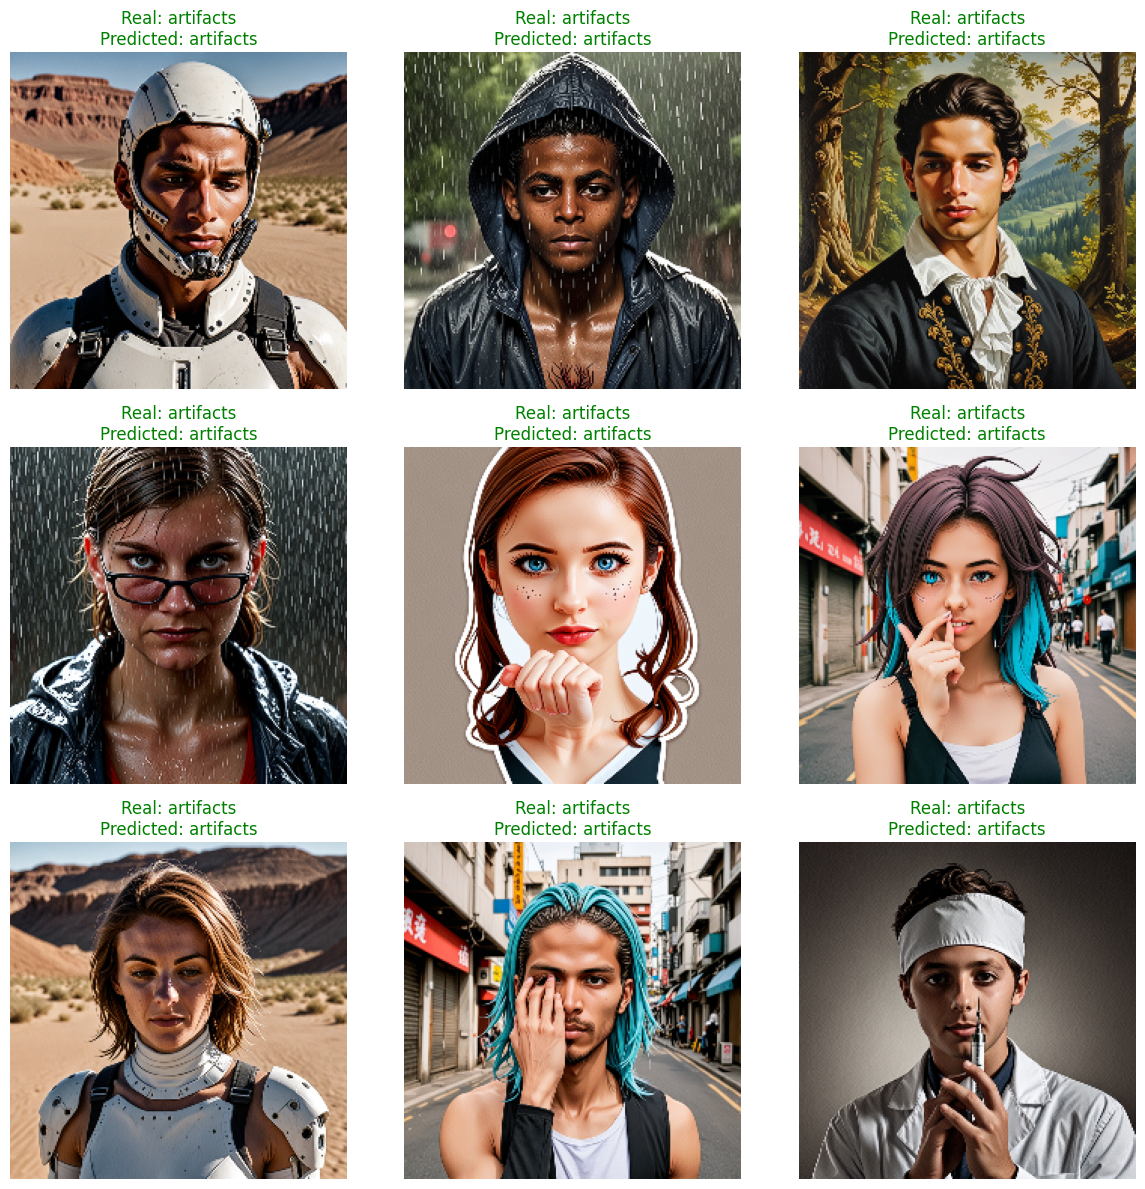

In [36]:
def visualize_model_predictions(model, test_dataset, classes, num_images=9):
    # Invert class dictionary to get class names by indexes
    class_names = {v: k for k, v in classes.items()}
    # Get the first batch_size of images and their labels
    images, labels = next(iter(test_dataset))
    if num_images > len(images):
        num_images = len(images)
    predictions = model.predict(images[:num_images])
    predicted_classes = np.argmax(predictions, axis=1)
    # Create a grid to display images
    rows = int(np.ceil(num_images / 3))
    cols = min(3, num_images)
    plt.figure(figsize=(12, 4 * rows))
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        # Display image
        img = images[i].numpy()
        plt.imshow(img)
        # Get real and predicted class labels
        true_label = int(labels[i].numpy())
        pred_label = predicted_classes[i]
        true_class_name = class_names[true_label]
        pred_class_name = class_names[pred_label]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"Real: {true_class_name}\nPredicted: {pred_class_name}",
                  color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


visualize_model_predictions(model=model, test_dataset=test_ds, classes=test_classes, num_images=9)